In [37]:
import pandas as pd
import json
from pathlib import Path
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../') 

from config import locations_age_csv
from config import vaccinations_age_csv
from config import vaccinations_manufacturer_csv
from config import full_data_csv

locations_age_df = pd.read_csv(locations_age_csv)
vaccinations_age_df = pd.read_csv(vaccinations_age_csv)
vaccinations_manufacturer_df = pd.read_csv(vaccinations_manufacturer_csv)
full_data_df = pd.read_csv(full_data_csv)

locations_age_df = locations_age_df.dropna()
vaccinations_age_df = vaccinations_age_df.dropna()
vaccinations_manufacturer_df = vaccinations_manufacturer_df.dropna()
full_data_df = full_data_df.dropna()

full_data = Path('../Resources/full_data.csv')
manufacturer_data = Path('../Resources/vaccinations-by-manufacturer.csv')
populations_data = Path('../Resources/world-population-data.csv')
full_data = pd.read_csv(full_data)
manufacturer_data = pd.read_csv(manufacturer_data)
pop_data = pd.read_csv(populations_data)
pop_data = pop_data[['location', '2022']]
pop_data.set_index('location')

,2022
location,
Aruba,106445.0
Africa Eastern and Southern,720859132.0
Afghanistan,41128771.0
Africa Western and Central,490330870.0
Angola,35588987.0
...,...
Kosovo,1761985.0
"Yemen, Rep.",33696614.0
South Africa,59893885.0


In [38]:
startdate = pd.Timestamp("2020-12-04")
enddate = pd.Timestamp("2024-04-17")

vaccinations_age_df['date'] = pd.to_datetime(vaccinations_age_df['date'])
vaccinations_manufacturer_df['date'] = pd.to_datetime(vaccinations_manufacturer_df['date'])
full_data_df['date'] = pd.to_datetime(full_data_df['date'])

vamask = (vaccinations_age_df['date'] >= startdate) & (vaccinations_age_df['date'] <= enddate)
vafiltered = vaccinations_age_df[vamask]

vmmask = (vaccinations_manufacturer_df['date'] >= startdate) & (vaccinations_manufacturer_df['date'] <= enddate)
vmfiltered = vaccinations_manufacturer_df[vmmask]

fdmask = (full_data_df['date'] >= startdate) & (full_data_df['date'] <= enddate)
fdfiltered = full_data_df[fdmask]

In [39]:
am_df = pd.merge(vafiltered, vmfiltered, how = "left", on = ["location", "date"])
am_df = am_df.dropna()
am_df.head()

,location,date,age_group,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,people_with_booster_per_hundred,vaccine,total_vaccinations
275,Argentina,2020-12-29,100+,0.0,0.0,0.0,Oxford/AstraZeneca,1.0
276,Argentina,2020-12-29,100+,0.0,0.0,0.0,Sinopharm/Beijing,1.0
277,Argentina,2020-12-29,100+,0.0,0.0,0.0,Sputnik V,20493.0
278,Argentina,2020-12-29,12-17,0.0,0.0,0.0,Oxford/AstraZeneca,1.0
279,Argentina,2020-12-29,12-17,0.0,0.0,0.0,Sinopharm/Beijing,1.0


In [40]:
am_df["age_group"].unique()
am_df["vaccine"].unique()

array(['Oxford/AstraZeneca', 'Sinopharm/Beijing', 'Sputnik V',
       'Pfizer/BioNTech', 'Moderna', 'CanSino', 'Sputnik Light',
       'Johnson&Johnson', 'Novavax', 'Sanofi/GSK', 'Valneva', 'Medicago',
       'Sinovac', 'Covaxin'], dtype=object)

In [41]:
age_mapping = {
    '100+': '80+',
    '60-69': '60-79',
    '70-79': '60-79',
    '80-89': '80+',
    '90-99': '80+',
    '80+': '80+',
    '12-17': '0-19',
    '3-11': '0-19',
    '0-15': '0-19',
    '0-4': '0-19',
    '5-9': '0-19',
    '0-17': '0-19',
    '5-11': '0-19',
    '0-19': '0-19',
    '10-14': '0-19',
    '15-17': '0-19',
    '0-5': '0-19',
    '20-29': '20-39',
    '30-39': '20-39',
    '40-49': '40-59',
    '50-59': '40-59',
    
    
}

In [42]:
am_df['new_age_group'] = am_df['age_group'].map(age_mapping)

In [43]:
amdf_vacgroups = am_df.groupby("age_group")["vaccine"]

In [44]:
amdf_vacgroups = am_df.groupby("new_age_group")["vaccine"]
amdf_vacgroups.describe()

,count,unique,top,freq
new_age_group,,,,
0-19,42193,14,Pfizer/BioNTech,11256
20-39,8989,11,Pfizer/BioNTech,2876
40-59,27001,14,Pfizer/BioNTech,7524
60-79,39861,14,Pfizer/BioNTech,11200
80+,29842,14,Pfizer/BioNTech,7448


In [45]:
testdf = am_df[["total_vaccinations", "new_age_group", "vaccine"]].groupby(["new_age_group", "vaccine"]).sum()
testdf.reset_index(inplace=True)

In [46]:
testmask = (testdf['vaccine'] == "Pfizer/BioNTech") & (testdf['vaccine'] == "Moderna") & (testdf['vaccine'] == "Sinopharm/Beijing") & (testdf['vaccine'] == "Oxford/AstraZeneca") & (testdf['vaccine'] == "Sputnik V")
testdffiltered = testdf[testmask]

In [47]:
vaccines_to_drop = ['CanSino', 'Covaxin', 'Medicago', 'Novavax', 'Sanofi/GSK', 'Sinovac', 'Sputnik Light', 'Valneva', 'Johnson&Johnson']
testdf = testdf[~testdf['vaccine'].isin(vaccines_to_drop)]

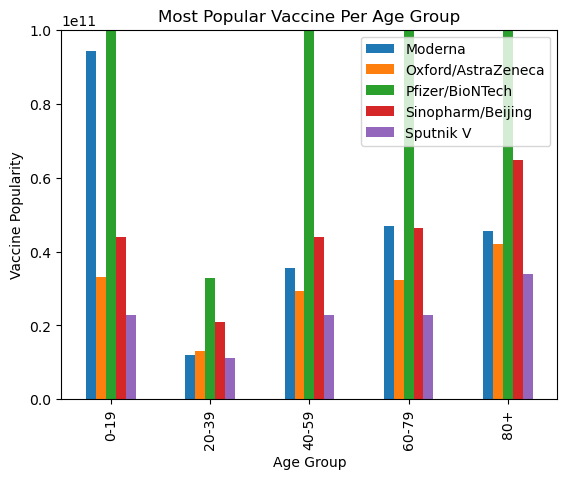

In [48]:
ax = testdf.pivot(index='new_age_group', columns='vaccine', values='total_vaccinations').plot(kind='bar')
ax.set_ylim(0, 10**11)
ax.set_xlabel('Age Group')
ax.set_ylabel('Vaccine Popularity')
ax.set_title('Most Popular Vaccine Per Age Group')
ax.legend(loc = "upper right")

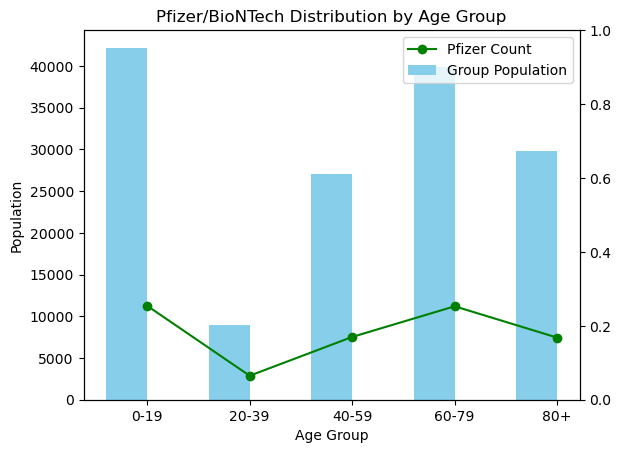

In [49]:
age_groups = ['0-19', '20-39', '40-59', '60-79', '80+']
group_count = [42193, 8989, 27001, 39861, 29842]
pfizer_count = [11256, 2876, 7524, 11200, 7448]

x= range(len(age_groups))
bar_width = .4
fig, ax = plt.subplots()
bar2 = ax.bar(x, group_count, bar_width, label='Group Population', color='skyblue')

ax2 = ax.twinx()
line = ax.plot([i + bar_width / 2 for i in x], pfizer_count, color='Green', marker='o', label='Pfizer Count')

ax.set_xlabel('Age Group')
ax.set_ylabel('Population')
ax.set_title('Pfizer/BioNTech Distribution by Age Group')
ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels(age_groups)
ax.legend()

plt.show()

In [50]:
testdf2 = am_df[["location", "total_vaccinations", "vaccine"]].groupby(["location", "vaccine"]).max()[["total_vaccinations"]]
testdf2.reset_index(inplace= True)
testdf2.sort_values(["location", "total_vaccinations"],ascending=[True,False])
testdf2.groupby("location").first()

,vaccine,total_vaccinations
location,,
Argentina,CanSino,989067.0
Austria,Johnson&Johnson,368544.0
Belgium,Johnson&Johnson,428653.0
Bulgaria,Johnson&Johnson,531805.0
Canada,Johnson&Johnson,23591.0
Croatia,Johnson&Johnson,205651.0
Cyprus,Johnson&Johnson,31066.0
Czechia,Covaxin,7.0
Denmark,Johnson&Johnson,45377.0


In [51]:
cmdf_countries = am_df.groupby("location")["vaccine"]
cmdf_countries.describe()

,count,unique,top,freq
location,,,,
Argentina,54439,7,Sinopharm/Beijing,10527
Austria,6163,7,Moderna,1299
Belgium,3500,5,Pfizer/BioNTech,973
Bulgaria,2957,4,Pfizer/BioNTech,972
Canada,2282,6,Pfizer/BioNTech,653
Croatia,4911,5,Pfizer/BioNTech,1335
Cyprus,3681,5,Pfizer/BioNTech,1208
Czechia,4721,10,Pfizer/BioNTech,1241
Denmark,3663,4,Pfizer/BioNTech,1027


In [52]:
cmdf_count = cmdf_countries.describe()
cmdf_count = cmdf_count["unique"]
cmdf_count.mean()

5.151515151515151

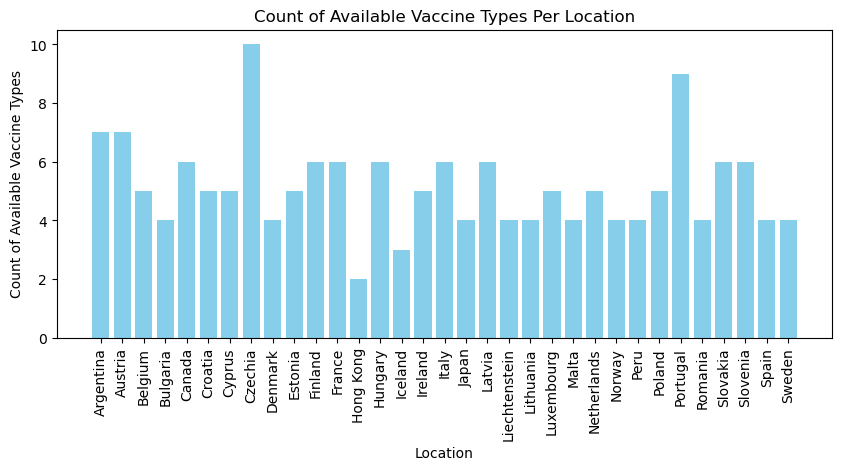

In [53]:
cmdf_count = am_df.groupby("location")["vaccine"].unique().apply(len).reset_index(name='count')

plt.figure(figsize=(10, 4))
plt.bar(cmdf_count["location"], cmdf_count["count"], color='skyblue')
plt.xlabel('Location')
plt.ylabel('Count of Available Vaccine Types')
plt.title('Count of Available Vaccine Types Per Location')
plt.xticks(rotation=90)
plt.show()

In [54]:
testdf = am_df[["total_vaccinations", "location", "vaccine"]].groupby(["location", "vaccine"]).sum()
testdf.reset_index(inplace=True)
testdf[testdf["location"]== "Hong Kong"]

,location,vaccine,total_vaccinations
70,Hong Kong,Pfizer/BioNTech,6.449191e+10
71,Hong Kong,Sinovac,4.611042e+10


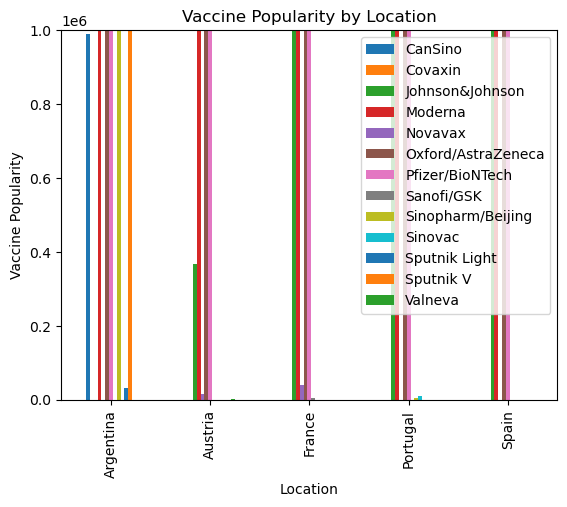

In [55]:
selected_locations = ['Argentina',
                      'Austria',
                      'France',
                      'Portugal',
                      'Spain'
                     ]
cmdfplot2 = testdf2[["total_vaccinations", "location", "vaccine"]].groupby(["location", "vaccine"]).sum()
# filtered_cmdfplot = cmdfplot[cmdfplot['vaccine'].isin(selected_vaccines)]
cmdfplot2.reset_index(inplace=True)
filtered_cmdfplot2 = testdf2[testdf2['location'].isin(selected_locations)]
# cmdfplot = testdf2[["total_vaccinations", "location", "vaccine"]].groupby(["location", "vaccine"]).sum()


filtered_cmdfplot2.reset_index(inplace=True)

ax = filtered_cmdfplot2.pivot(index='location', columns='vaccine', values='total_vaccinations').plot(kind='bar')
ax.set_ylim(0, 10**6)
ax.set_xlabel('Location')
ax.set_ylabel('Vaccine Popularity')
ax.set_title('Vaccine Popularity by Location')
ax.legend(loc = "upper right")

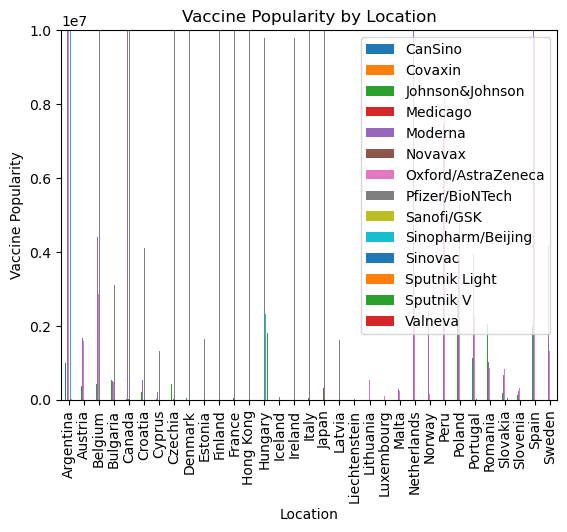

In [56]:
cmdfplot = testdf2[["total_vaccinations", "location", "vaccine"]].groupby(["location", "vaccine"]).sum()


cmdfplot.reset_index(inplace=True)

ax = cmdfplot.pivot(index='location', columns='vaccine', values='total_vaccinations').plot(kind='bar')
ax.set_ylim(0, 10**7)
ax.set_xlabel('Location')
ax.set_ylabel('Vaccine Popularity')
ax.set_title('Vaccine Popularity by Location')
ax.legend(loc = "upper right")

In [57]:
countries_to_drop = ["Belgium",           
"Bulgaria",          
"Canada",            
"Croatia",           
"Cyprus",            
"Czechia",          
"Denmark",           
"Estonia",           
"Finland",          
"France",
"Hungary",           
"Iceland",           
"Ireland",           
"Italy",             
"Japan",             
"Latvia",            
"Liechtenstein",     
"Lithuania",         
"Luxembourg",        
"Malta",            
"Netherlands",       
"Norway",            
"Peru",
"Portugal",
"Slovakia",          
"Slovenia",          
"Spain",             
"Sweden"]
cmdfplot = cmdfplot[~cmdfplot['location'].isin(countries_to_drop)]

In [58]:
cmdfplot

,location,vaccine,total_vaccinations
0,Argentina,CanSino,989067.0
1,Argentina,Moderna,18714178.0
2,Argentina,Oxford/AstraZeneca,26782388.0
3,Argentina,Pfizer/BioNTech,20715299.0
4,Argentina,Sinopharm/Beijing,28986044.0
5,Argentina,Sputnik Light,32707.0
6,Argentina,Sputnik V,20758838.0
7,Austria,Johnson&Johnson,368544.0
8,Austria,Moderna,1666123.0
9,Austria,Novavax,15073.0


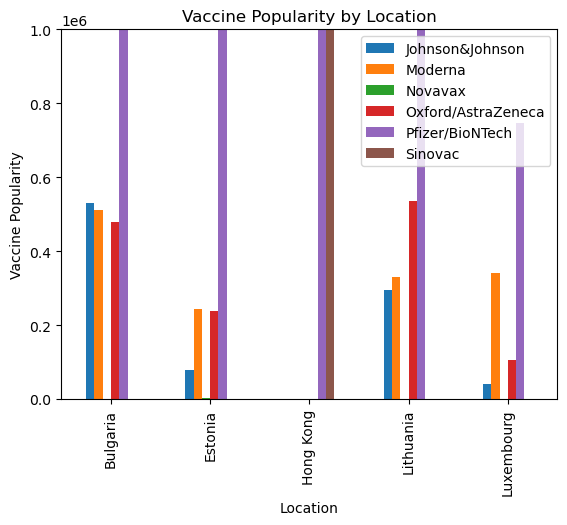

In [59]:
selected_locations = ['Estonia',
                      'Lithuania',
                      'Luxembourg',
                      'Bulgaria',
                      'Hong Kong'
                     ]
cmdfplot = testdf2[["total_vaccinations", "location", "vaccine"]].groupby(["location", "vaccine"]).sum()
# filtered_cmdfplot = cmdfplot[cmdfplot['vaccine'].isin(selected_vaccines)]
cmdfplot.reset_index(inplace=True)
filtered_cmdfplot = testdf2[testdf2['location'].isin(selected_locations)]


# filtered_cmdfplot.reset_index(inplace=True)

ax = filtered_cmdfplot.pivot(index='location', columns='vaccine', values='total_vaccinations').plot(kind='bar')
ax.set_ylim(0, 10**6)
ax.set_xlabel('Location')
ax.set_ylabel('Vaccine Popularity')
ax.set_title('Vaccine Popularity by Location')
ax.legend(loc = "upper right")

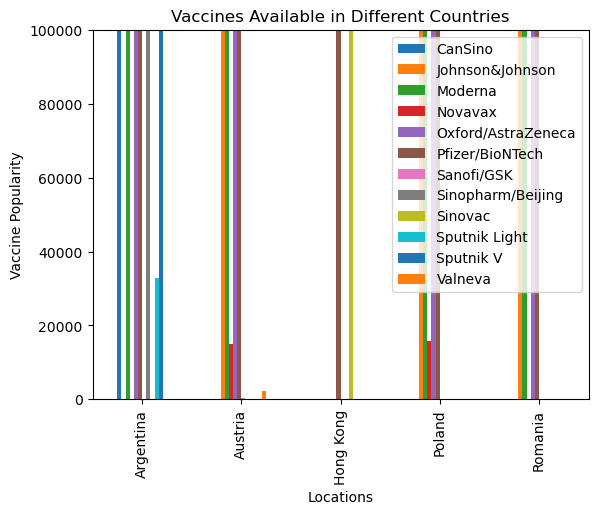

In [60]:
selected_locations = ['Argentina', 'Austria', 'Hong Kong', 'Poland', 'Romania']

filtered_cmdfplot = cmdfplot[(cmdfplot['location'].isin(selected_locations))]
filtered_cmdfplot.reset_index(drop=True, inplace=True)

# Create the bar plot for the filtered data
ax = filtered_cmdfplot.pivot(index='location', columns='vaccine', values='total_vaccinations').plot(kind='bar')

# Set the plot properties
ax.set_ylim(0, 10**5)
ax.set_xlabel('Locations')
ax.set_ylabel('Vaccine Popularity')
ax.set_title('Vaccines Available in Different Countries')
ax.legend(loc="upper right")

# Show the plot
plt.show()



In [61]:
# selected_locations = ['Argentina', 'Austria', 'Hong Kong', 'Poland', 'Romania']
# selected_vaccines = ['Pfizer, Moderna']

# filtered_cmdfplot = cmdfplot[(cmdfplot['vaccine'].isin(selected_vaccines)) & (cmdfplot['location'].isin(selected_locations))]
# filtered_cmdfplot.reset_index(drop=True, inplace=True)

# # Create the bar plot for the filtered data
# ax = filtered_cmdfplot.pivot(index='location', columns='vaccine', values='total_vaccinations').plot(kind='bar')

# # Set the plot properties
# ax.set_ylim(0, 10**7)
# ax.set_xlabel('Locations')
# ax.set_ylabel('Vaccine Popularity')
# ax.set_title('Other Popular Vaccines for Selected Locations')
# ax.legend(loc="upper right")

# # Show the plot
# plt.show()


In [62]:
total_cases = full_data.drop(columns=['new_cases','new_deaths','weekly_cases','weekly_deaths','biweekly_deaths','biweekly_cases'])
total_cases = total_cases.dropna()
total_cases = total_cases.groupby(['location']).max('total_cases')
total_cases = total_cases.rename(columns={'total_cases':'Total Cases', 'total_deaths':'Total Deaths'})
total_cases = pd.DataFrame(total_cases)
drop_values = ['South America','World','High income','Asia','Europe','Upper middle income','European Union','North America','Lower middle income']
total_cases = total_cases.drop(index = drop_values)
top_cases = total_cases.nlargest(n=10,columns='Total Cases')

In [63]:
manufacturer_data = manufacturer_data.groupby(['location','vaccine']).max('total_vaccinations')
manufacturer_data = manufacturer_data.groupby('location').sum('total_vaccinations')
manufacturer_data = manufacturer_data.rename(columns={'total_vaccinations':'Total Vaccinations'})
manufacturer_data = manufacturer_data.drop(index = 'European Union')

In [64]:
vax_case_ratio = pd.merge(total_cases, manufacturer_data, how='inner', on='location')
vax_case_ratio['Vaccinations:Cases'] = vax_case_ratio['Total Vaccinations'] / vax_case_ratio['Total Cases']
vax_case_ratio['Vaccinations:Deaths'] = vax_case_ratio['Total Vaccinations'] / vax_case_ratio['Total Deaths']
top_vaxcase_ratio = vax_case_ratio.nlargest(n=10,columns='Vaccinations:Cases')
top_vaxdeath_ratio = vax_case_ratio.nlargest(n=10,columns='Vaccinations:Deaths')
vax_rates = pd.merge(vax_case_ratio, pop_data, how='left', on='location')
vax_rates['Vaccination Rate'] = vax_rates['Total Vaccinations'] / vax_rates['2022']
vax_rates = vax_rates.set_index('location')
vax_rates = vax_rates.dropna()
vax_rates = vax_rates.sort_values('Vaccination Rate', ascending=False)

In [65]:
top_vax = manufacturer_data.nlargest(n=10,columns='Total Vaccinations')
low_vax = manufacturer_data.nsmallest(n=10,columns='Total Vaccinations')

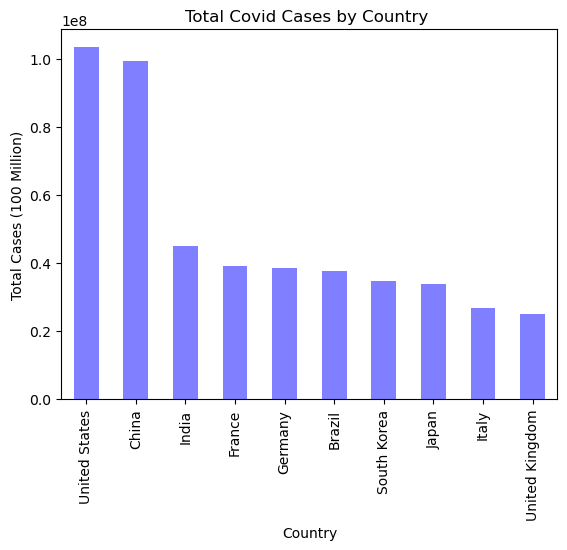

In [66]:
vax_rates_top = vax_rates.nlargest(n=10,columns='Vaccination Rate')
vax_rates_bottom = vax_rates.nsmallest(n=10,columns='Vaccination Rate')
top_cases_chart = top_cases['Total Cases'].plot(kind='bar', color='blue', alpha=0.5, xlabel='Country', ylabel='Total Cases (100 Million)', title='Total Covid Cases by Country ')

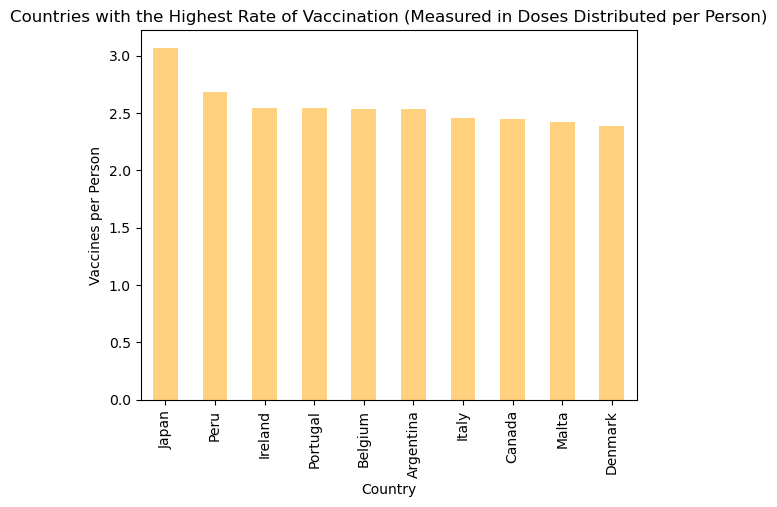

In [67]:
plot_top_vax_rate = vax_rates.nlargest(n=10,columns='Vaccination Rate')
plot_top_vax_rate = plot_top_vax_rate['Vaccination Rate'].plot(
    kind='bar', color='orange', alpha=0.5, xlabel='Country',
    ylabel='Vaccines per Person', title='Countries with the Highest Rate of Vaccination (Measured in Doses Distributed per Person)'
)

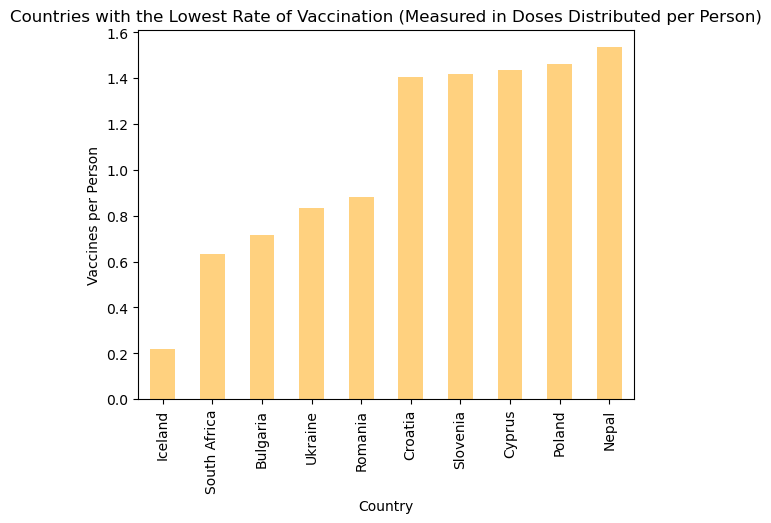

In [68]:
plot_bottom_vax_rate = vax_rates.nsmallest(n=10,columns='Vaccination Rate')
plot_bottom_vax_rate = plot_bottom_vax_rate['Vaccination Rate'].plot(
    kind='bar', color='orange', alpha=0.5, xlabel='Country',
    ylabel='Vaccines per Person', title='Countries with the Lowest Rate of Vaccination (Measured in Doses Distributed per Person)'
)

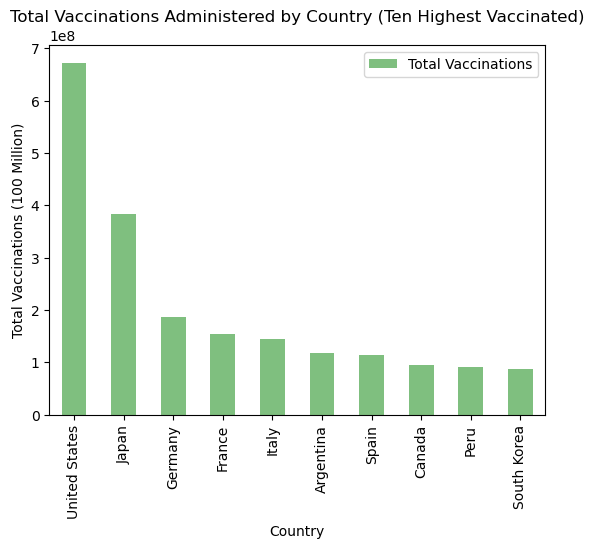

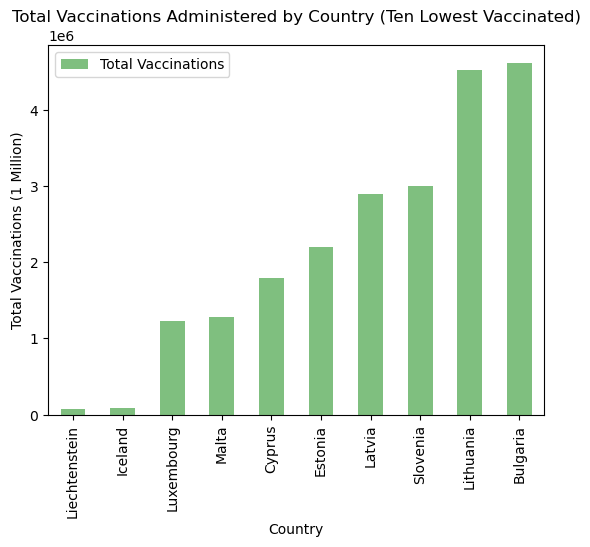

In [69]:
vax_rates['Total Vaccinations'].describe()
vax_rates['Vaccination Rate'].describe()
top_vax_chart = top_vax.plot(kind='bar',color='green',alpha=0.5,xlabel='Country',ylabel='Total Vaccinations (100 Million)', title='Total Vaccinations Administered by Country (Ten Highest Vaccinated)')
low_vax_chart = low_vax.plot(kind='bar',color='green',alpha=0.5,xlabel='Country',ylabel='Total Vaccinations (1 Million)', title='Total Vaccinations Administered by Country (Ten Lowest Vaccinated)')

In [70]:
drop_values = ['Vaccinations:Cases','Vaccinations:Deaths','Total Deaths', '2022']
vax_stat = vax_rates.drop(columns=drop_values)
vax_stat['Case Rate'] = vax_rates['Total Cases'] / vax_rates['2022']
vax_stat.corr(method='pearson')

,Total Cases,Total Vaccinations,Vaccination Rate,Case Rate
Total Cases,1.000000,0.951295,0.247330,0.032366
Total Vaccinations,0.951295,1.000000,0.312504,-0.116917
Vaccination Rate,0.247330,0.312504,1.000000,0.104211
Case Rate,0.032366,-0.116917,0.104211,1.000000
